In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as pl
import seaborn as sns
import numpy as np

In [3]:
data = pd.read_excel('NMC2 (1-42) deltav.xlsx')
data

,Cycle,V_m (V),Current (A),Capacity (AH),SoC (%),SoHcyc,SoH (%),DeltaV (V)
0,1,4.117,0.998,0.000277,99.990759,0.009241,97.887574,0.000
1,1,4.116,0.999,0.000555,99.981509,0.018491,97.887574,0.001
2,1,4.115,0.998,0.000832,99.972269,0.027731,97.887574,0.002
3,1,4.114,0.998,0.001109,99.963028,0.036972,97.887574,0.003
4,1,4.113,0.997,0.001386,99.953796,0.046204,97.887574,0.004
...,...,...,...,...,...,...,...,...
422981,42,2.510,1.000,2.704505,9.849824,90.150176,90.187213,1.607
422982,42,2.507,1.000,2.704783,9.840565,90.159435,90.187213,1.610
422983,42,2.504,1.000,2.705061,9.831306,90.168694,90.187213,1.613
422984,42,2.501,1.000,2.705339,9.822046,90.177954,90.187213,1.616


# LSTM

In [33]:
X=data[['V_m (V)','Current (A)','DeltaV (V)','Capacity (AH)','DoD (%)']]
y=data['SoHcyc'].values
std=StandardScaler()
X_std=std.fit_transform(X)

train_size=int(0.7*len(X_std))
test_size=int(0.9*len(X_std))
X_train=X_std[:train_size]
X_val=X_std[train_size:test_size]
X_test=X_std[test_size:]

X_train=X_train.reshape(-1,1,5)
X_val=X_val.reshape(-1,1,5)
X_test=X_test.reshape(-1,1,5)

y_train=y[:train_size]
y_val=y[train_size:test_size]
y_test=y[test_size:]

y_train=y_train.reshape(-1,1,1)
y_val=y_val.reshape(-1,1,1)
y_test=y_test.reshape(-1,1,1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/30
50/50 [==============================] - 3s 13ms/step - loss: 624.9836 - mae: 15.4724 - mse: 624.9836 - val_loss: 9.1627 - val_mae: 2.5505 - val_mse: 9.1627
Epoch 2/30
50/50 [==============================] - 0s 5ms/step - loss: 2.2167 - mae: 1.0789 - mse: 2.2167 - val_loss: 0.4230 - val_mae: 0.5222 - val_mse: 0.4230
Epoch 3/30
50/50 [==============================] - 0s 5ms/step - loss: 0.3070 - mae: 0.4251 - mse: 0.3070 - val_loss: 0.1487 - val_mae: 0.3035 - val_mse: 0.1487
Epoch 4/30
50/5

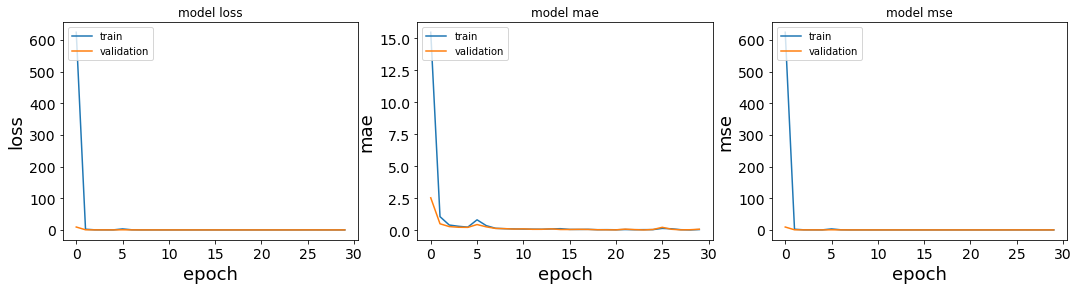

In [34]:
output_layers=1
model=tf.keras.Sequential([
    tf.keras.layers.LSTM(32,input_shape=(X_train.shape[1],X_train.shape[2]),activation='relu'),
    tf.keras.layers.Dense(output_layers,activation='linear')
])
print(model.summary())
print('\n')

model.compile(loss='mse',optimizer=tf.optimizers.Adam(learning_rate=0.1),metrics=['mae','mse'])
history=model.fit(X_train,y_train,
                  epochs=30,
                  batch_size=100,
                  verbose=1,
                  steps_per_epoch=50,
                  validation_data=(X_val,y_val),
                  validation_steps=50,
                  validation_batch_size=150
                 )


fig,ax=pl.subplots(nrows=1,ncols=3,figsize=(18,4))
metric=['loss','mae','mse']
for i in range(3):
    ax[i].plot(history.history['{}'.format(metric[i])])
    ax[i].plot(history.history['val_{}'.format(metric[i])])
    ax[i].set_title('model {}'.format(metric[i]))
    ax[i].set_ylabel('{}'.format(metric[i]))
    ax[i].set_xlabel('epoch')
    ax[i].legend(['train', 'validation'], loc='upper left')

In [43]:
model.save('NMC2LSTM.allfitur')

INFO:tensorflow:Assets written to: NMC2LSTM.allfitur\assets


In [34]:
from tensorflow.keras.models import load_model
model = load_model('NMC2LSTM.allfitur')

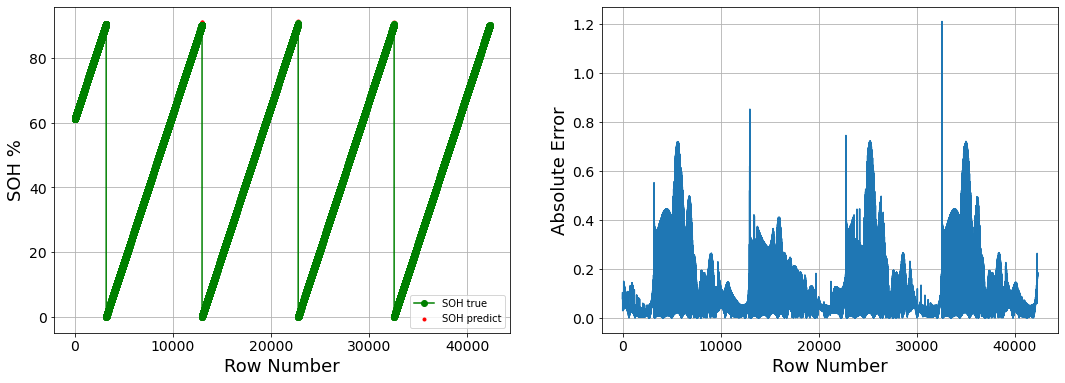

In [35]:
y_pred=model.predict(X_test)
fig,ax=pl.subplots(1,2,figsize=(18,6))
abs_error=np.abs(y_pred.reshape(-1)-y_test.reshape(-1))

ax[0].scatter(range(len(y_test.reshape(-1))),y_pred.reshape(-1),label='SOH predict',marker='.',color='red')
ax[0].plot(range(len(y_test.reshape(-1))),y_test.reshape(-1),label='SOH true',marker='o',color='green')
ax[0].set_xlabel('Row Number')
ax[0].set_ylabel('SOH %')
ax[0].legend()
ax[0].grid()

ax[1].plot(range(len(y_test.reshape(-1))),abs_error)
ax[1].set_xlabel('Row Number')
ax[1].set_ylabel('Absolute Error')
ax[1].grid()

In [103]:
from tensorflow.keras.models import load_model
model = load_model('NMC2LSTM.allfitur')

In [35]:
y_pred_all=model.predict(X_std.reshape(-1,1,5)).reshape(-1)

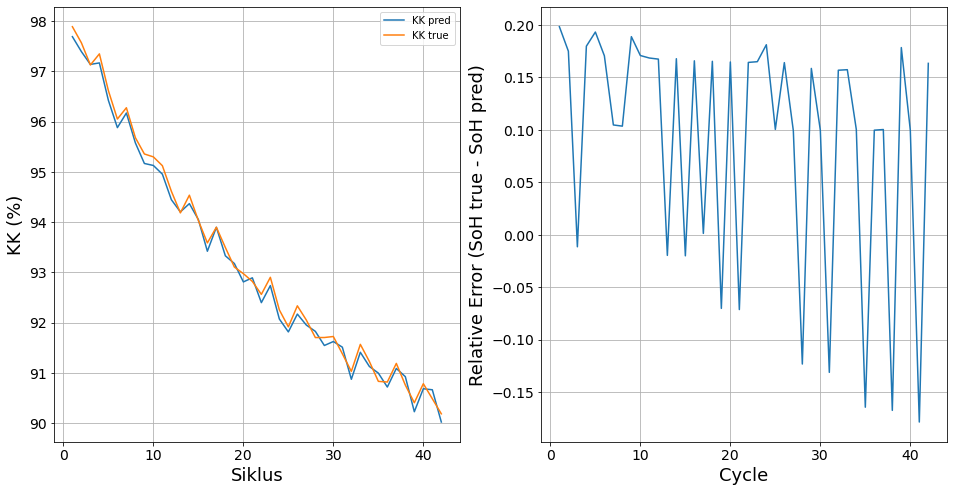

In [36]:
data['SOH_pred']=y_pred_all
data['selisih']=0
data['selisih']=data.SOH_pred.iloc[1:].reset_index(drop=True)-data.SOH_pred[:-1].reset_index(drop=True)

cyc_dat=pd.DataFrame()
for cyc in data.Cycle.unique():
    df=data[data['Cycle']==cyc]
    cyc_dat=cyc_dat.append(df.iloc[-1])

cyc_dat.reset_index(drop=True)

fig,ax=pl.subplots(1,2,figsize=(16,8))
ax[0].plot(cyc_dat.Cycle,cyc_dat.SOH_pred,label='KK pred')
ax[0].plot(cyc_dat.Cycle,cyc_dat.SoHcyc,label='KK true')
ax[0].set_xlabel('Siklus')
ax[0].set_ylabel('KK (%)')
#ax[0].set_ylim(80,95)
ax[0].legend()
ax[0].grid()

ax[1].plot(cyc_dat.Cycle,cyc_dat.SoHcyc-cyc_dat.SOH_pred)
ax[1].set_xlabel('Cycle')
ax[1].set_ylabel('Relative Error (SoH true - SoH pred)')
ax[1].grid()

pl.rcParams['axes.labelsize'] = 18
pl.rcParams['xtick.labelsize'] = 14
pl.rcParams['ytick.labelsize'] = 14

In [37]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt

#predY=model.predict(X_test)
MSE=mean_squared_error(y,y_pred_all)
MAE=mean_absolute_error(y,y_pred_all)
RMSE=sqrt(mean_squared_error(y,y_pred_all))
Skor=r2_score(y,y_pred_all)
print('MSE prediksi/estimasi pada data tes=',MSE)
print('MSE prediksi/estimasi pada data tes=',Skor)
print('MAE prekdisi/estimasi pada data tes=',MAE)
print('RMSE prekdisi/estimasi pada data tes=',RMSE)

MSE prediksi/estimasi pada data tes= 0.025625012695581602
MSE prediksi/estimasi pada data tes= 0.9999647736817503
MAE prekdisi/estimasi pada data tes= 0.09955501805590364
RMSE prekdisi/estimasi pada data tes= 0.16007814559015107


In [42]:
def mape(y, y_pred_all): 
    y, y_pred_all = np.array(y), np.array(y_pred_all)
    return np.mean(np.abs((y - y_pred_all) / y)) * 100

print('MAPE prekdisi =',mape(y, y_pred_all) )

MAPE prekdisi = 2.1187271994771946


# DNN - Linear

In [38]:
X=data[['V_m (V)','Current (A)','DeltaV (V)','Capacity (AH)','DoD (%)']]
y=data['SoHcyc'].values
std=StandardScaler()
X_std=std.fit_transform(X)

train_size=int(0.7*len(X_std))
test_size=int(0.9*len(X_std))
X_train=X_std[:train_size] #70%
X_val=X_std[train_size:test_size] #20%
X_test=X_std[test_size:] #10%

y_train=y[:train_size]
y_val=y[train_size:test_size]
y_test=y[test_size:]


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 6)                 36        
_________________________________________________________________
dense_26 (Dense)             (None, 42298)             296086    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 42299     
Total params: 338,421
Trainable params: 338,421
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/40
50/50 [==============================] - 4s 59ms/step - loss: 2399.6841 - mae: 19.4465 - mse: 2399.6841 - val_loss: 29.4611 - val_mae: 4.4989 - val_mse: 29.4611
Epoch 2/40
50/50 [==============================] - 2s 43ms/step - loss: 13.6806 - mae: 2.7384 - mse: 13.6806 - val_loss: 4.8862 - val_mae: 1.6305 - val_mse: 4.8862
Epoch 3/40
50/50 [===============

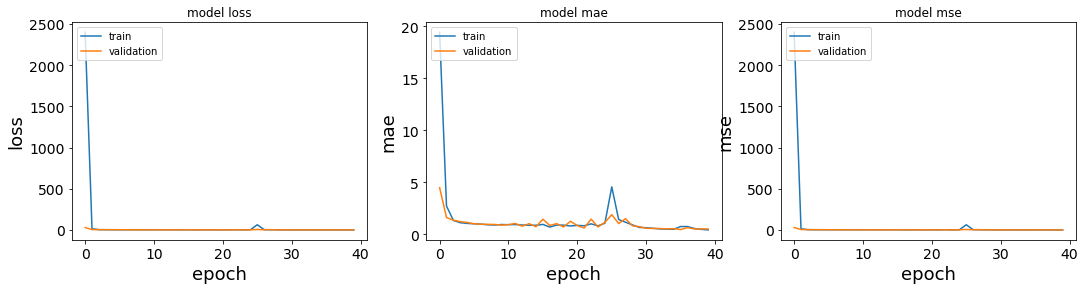

In [116]:
input_layers=X.shape[1]+1
output_layers=1
factor=1 #1-10
hidden_layers=int(len(X_train)/(factor*(input_layers+output_layers)))

model=tf.keras.Sequential([
    tf.keras.layers.Dense(input_layers, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'),
    tf.keras.layers.Dense(hidden_layers,activation='relu'),
    tf.keras.layers.Dense(output_layers,activation='linear')
])
print(model.summary())
print('\n')

model.compile(loss='mse',optimizer=tf.optimizers.Adam(learning_rate=0.1),metrics=['mae','mse'])
history=model.fit(X_train,y_train,
                  epochs=40,
                  batch_size=100,
                  verbose=1,
                  steps_per_epoch=50,
                  validation_data=(X_val,y_val),
                  validation_steps=50,
                  validation_batch_size=150
                 )


fig,ax=pl.subplots(nrows=1,ncols=3,figsize=(18,4))
metric=['loss','mae','mse']
for i in range(3):
    ax[i].plot(history.history['{}'.format(metric[i])])
    ax[i].plot(history.history['val_{}'.format(metric[i])])
    ax[i].set_title('model {}'.format(metric[i]))
    ax[i].set_ylabel('{}'.format(metric[i]))
    ax[i].set_xlabel('epoch')
    ax[i].legend(['train', 'validation'], loc='upper left')

In [121]:
model.save('NMC2DNN.allfitur')

INFO:tensorflow:Assets written to: NMC2DNN.allfitur\assets


In [39]:
model=load_model('NMC2DNN.allfitur')

In [40]:
y_pred_all=model.predict(X_std).reshape(-1)

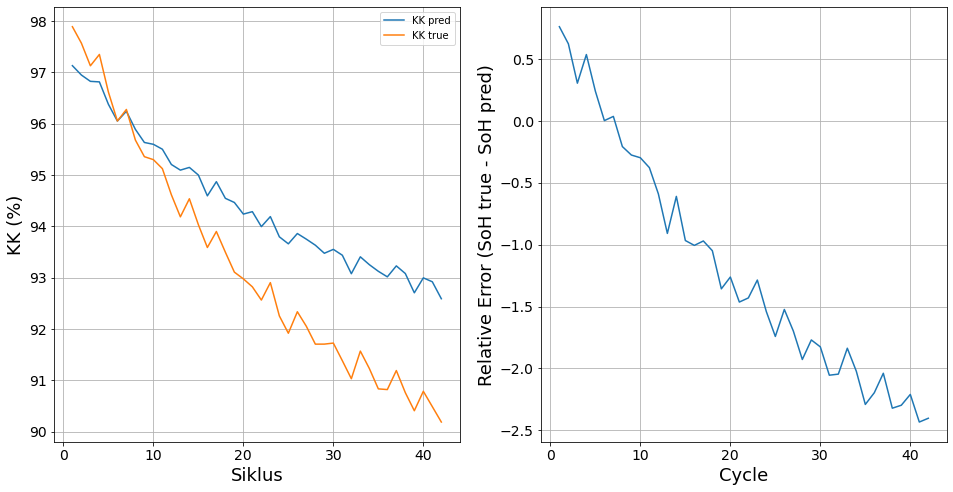

In [14]:
data['SOH_pred']=y_pred_all
data['selisih']=0
data['selisih']=data.SOH_pred.iloc[1:].reset_index(drop=True)-data.SOH_pred[:-1].reset_index(drop=True)

cyc_dat=pd.DataFrame()
for cyc in data.Cycle.unique():
    df=data[data['Cycle']==cyc]
    cyc_dat=cyc_dat.append(df.iloc[-1])

cyc_dat.reset_index(drop=True)

fig,ax=pl.subplots(1,2,figsize=(16,8))
ax[0].plot(cyc_dat.Cycle,cyc_dat.SOH_pred,label='KK pred')
ax[0].plot(cyc_dat.Cycle,cyc_dat.SoHcyc,label='KK true')
ax[0].set_xlabel('Siklus')
ax[0].set_ylabel('KK (%)')
#ax[0].set_ylim(80,95)
ax[0].legend()
ax[0].grid()

ax[1].plot(cyc_dat.Cycle,cyc_dat.SoHcyc-cyc_dat.SOH_pred)
ax[1].set_xlabel('Cycle')
ax[1].set_ylabel('Relative Error (SoH true - SoH pred)')
ax[1].grid()

pl.rcParams['axes.labelsize'] = 18
pl.rcParams['xtick.labelsize'] = 14
pl.rcParams['ytick.labelsize'] = 14

In [41]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt

#predY=model.predict(X_test)
MSE=mean_squared_error(y,y_pred_all)
MAE=mean_absolute_error(y,y_pred_all)
RMSE=sqrt(mean_squared_error(y,y_pred_all))
Skor=r2_score(y,y_pred_all)
print('MSE prediksi/estimasi pada data tes=',MSE)
print('MSE prediksi/estimasi pada data tes=',Skor)
print('MAE prekdisi/estimasi pada data tes=',MAE)
print('RMSE prekdisi/estimasi pada data tes=',RMSE)

MSE prediksi/estimasi pada data tes= 0.3218494936568091
MSE prediksi/estimasi pada data tes= 0.9995575583580488
MAE prekdisi/estimasi pada data tes= 0.407495831220528
RMSE prekdisi/estimasi pada data tes= 0.5673178065747708


In [120]:
def mape(y, y_pred_all): 
    y, y_pred_all = np.array(y), np.array(y_pred_all)
    return np.mean(np.abs((y - y_pred_all) / y)) * 100

print('MAPE prekdisi =',mape(y, y_pred_all) )

MAPE prekdisi = 3.8746818258146543


# Simple RNN

In [42]:
X=data[['V_m (V)','Current (A)','DeltaV (V)','Capacity (AH)','DoD (%)']]
y=data['SoHcyc'].values
std=StandardScaler()
X_std=std.fit_transform(X)

train_size=int(0.7*len(X_std))
test_size=int(0.9*len(X_std))
X_train=X_std[:train_size]
X_val=X_std[train_size:test_size]
X_test=X_std[test_size:]

X_train=X_train.reshape(-1,1,5)
X_val=X_val.reshape(-1,1,5)
X_test=X_test.reshape(-1,1,5)

y_train=y[:train_size]
y_val=y[train_size:test_size]
y_test=y[test_size:]

y_train=y_train.reshape(-1,1,1)
y_val=y_val.reshape(-1,1,1)
y_test=y_test.reshape(-1,1,1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1216      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/40
50/50 [==============================] - 2s 10ms/step - loss: 503.1725 - mae: 13.7449 - mse: 503.1725 - val_loss: 6.2360 - val_mae: 1.8919 - val_mse: 6.2360
Epoch 2/40
50/50 [==============================] - 0s 4ms/step - loss: 2.8289 - mae: 1.0509 - mse: 2.8289 - val_loss: 0.5821 - val_mae: 0.6142 - val_mse: 0.5821
Epoch 3/40
50/50 [==============================] - 0s 4ms/step - loss: 0.3529 - mae: 0.4464 - mse: 0.3529 - val_loss: 0.2145 - val_mae: 0.3668 - val_mse: 0.2145
Epoch 4/40
50/5

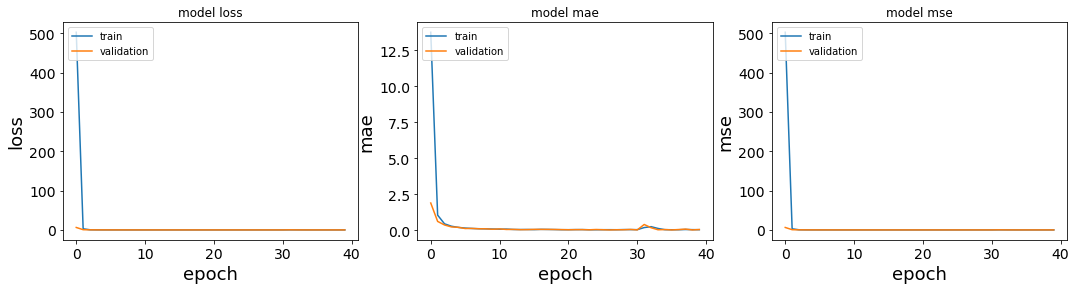

In [57]:
output_layers=1
model=tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=(X_train.shape[1],X_train.shape[2]),activation='relu'),
    tf.keras.layers.Dense(output_layers,activation='linear')
])
print(model.summary())
print('\n')

model.compile(loss='mse',optimizer=tf.optimizers.Adam(learning_rate=0.1),metrics=['mae','mse'])
history=model.fit(X_train,y_train,
                  epochs=40,
                  batch_size=100,
                  verbose=1,
                  steps_per_epoch=50,
                  validation_data=(X_val,y_val),
                  validation_steps=50,
                  validation_batch_size=150
                 )


fig,ax=pl.subplots(nrows=1,ncols=3,figsize=(18,4))
metric=['loss','mae','mse']
for i in range(3):
    ax[i].plot(history.history['{}'.format(metric[i])])
    ax[i].plot(history.history['val_{}'.format(metric[i])])
    ax[i].set_title('model {}'.format(metric[i]))
    ax[i].set_ylabel('{}'.format(metric[i]))
    ax[i].set_xlabel('epoch')
    ax[i].legend(['train', 'validation'], loc='upper left')

In [62]:
model.save('NMC2RNN.allfitur')

INFO:tensorflow:Assets written to: NMC2RNN.allfitur\assets


In [43]:
model=load_model('NMC2RNN.allfitur')

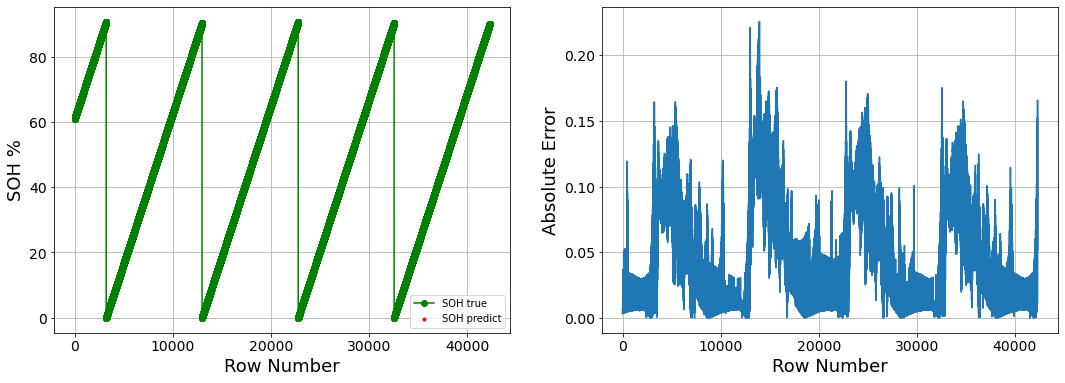

In [63]:
y_pred=model.predict(X_test)
fig,ax=pl.subplots(1,2,figsize=(18,6))
abs_error=np.abs(y_pred.reshape(-1)-y_test.reshape(-1))

ax[0].scatter(range(len(y_test.reshape(-1))),y_pred.reshape(-1),label='SOH predict',marker='.',color='red')
ax[0].plot(range(len(y_test.reshape(-1))),y_test.reshape(-1),label='SOH true',marker='o',color='green')
ax[0].set_xlabel('Row Number')
ax[0].set_ylabel('SOH %')
ax[0].legend()
ax[0].grid()

ax[1].plot(range(len(y_test.reshape(-1))),abs_error)
ax[1].set_xlabel('Row Number')
ax[1].set_ylabel('Absolute Error')
ax[1].grid()

In [44]:
y_pred_all=model.predict(X_std.reshape(-1,1,5)).reshape(-1)

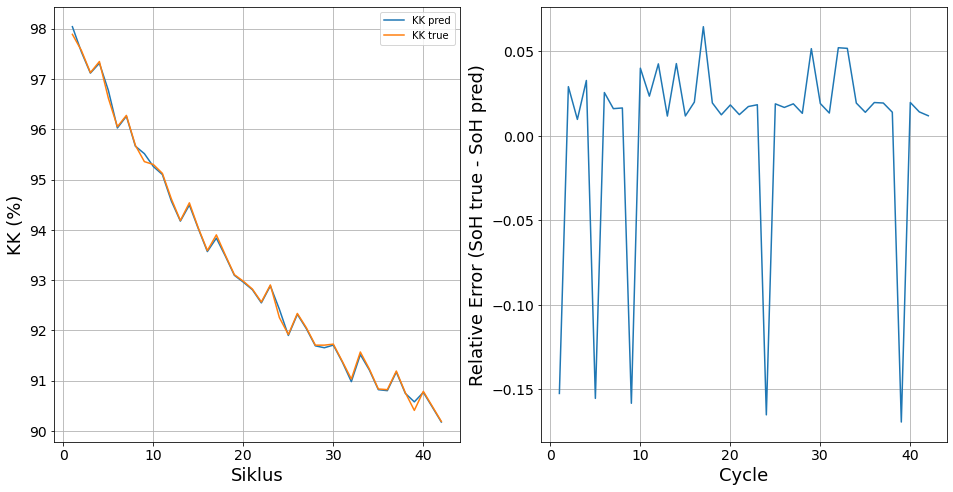

In [18]:
data['SOH_pred']=y_pred_all
data['selisih']=0
data['selisih']=data.SOH_pred.iloc[1:].reset_index(drop=True)-data.SOH_pred[:-1].reset_index(drop=True)

cyc_dat=pd.DataFrame()
for cyc in data.Cycle.unique():
    df=data[data['Cycle']==cyc]
    cyc_dat=cyc_dat.append(df.iloc[-1])

cyc_dat.reset_index(drop=True)

fig,ax=pl.subplots(1,2,figsize=(16,8))
ax[0].plot(cyc_dat.Cycle,cyc_dat.SOH_pred,label='KK pred')
ax[0].plot(cyc_dat.Cycle,cyc_dat.SoHcyc,label='KK true')
ax[0].set_xlabel('Siklus')
ax[0].set_ylabel('KK (%)')
#ax[0].set_ylim(80,95)
ax[0].legend()
ax[0].grid()

ax[1].plot(cyc_dat.Cycle,cyc_dat.SoHcyc-cyc_dat.SOH_pred)
ax[1].set_xlabel('Cycle')
ax[1].set_ylabel('Relative Error (SoH true - SoH pred)')
ax[1].grid()

pl.rcParams['axes.labelsize'] = 18
pl.rcParams['xtick.labelsize'] = 14
pl.rcParams['ytick.labelsize'] = 14

In [45]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt

#predY=model.predict(X_test)
MSE=mean_squared_error(y,y_pred_all)
MAE=mean_absolute_error(y,y_pred_all)
RMSE=sqrt(mean_squared_error(y,y_pred_all))
Skor=r2_score(y,y_pred_all)
print('MSE prediksi/estimasi pada data tes=',MSE)
print('Score prediksi/estimasi pada data tes=',Skor)
print('MAE prekdisi/estimasi pada data tes=',MAE)
print('RMSE prekdisi/estimasi pada data tes=',RMSE)

MSE prediksi/estimasi pada data tes= 0.0026536061637079567
MSE prediksi/estimasi pada data tes= 0.9999963521276519
MAE prekdisi/estimasi pada data tes= 0.0382546783067798
RMSE prekdisi/estimasi pada data tes= 0.05151316495526126


In [61]:
def mape(y, y_pred_all): 
    y, y_pred_all = np.array(y), np.array(y_pred_all)
    return np.mean(np.abs((y - y_pred_all) / y)) * 100

print('MAPE prekdisi =',mape(y, y_pred_all) )

MAPE prekdisi = 0.704119784239414


# SVR

In [5]:
from sklearn.model_selection import train_test_split

X=data[['V_m (V)','Current (A)','DeltaV (V)','Capacity (AH)','SoC (%)']]
y=data['SoHcyc'].values
std=StandardScaler()
X_std=std.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=.2, random_state=42)

In [6]:
from sklearn.svm import SVR

#regressor = SVR(**{'C': 8, 'epsilon': 2, 'gamma': 'scale', 'kernel': 'rbf'})
regressor = SVR(**{'C': 10, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'rbf'})

In [7]:
regressor.fit(X_train, y_train)

SVR(C=10, epsilon=1)

In [8]:
SoH_pred=regressor.predict(X_std)
data['SoH_pred']=SoH_pred
data

,Cycle,V_m (V),Current (A),Capacity (AH),SoC (%),SoHcyc,SoH (%),DeltaV (V),SoH_pred
0,1,4.117,0.998,0.000277,99.990759,0.009241,97.887574,0.000,0.963463
1,1,4.116,0.999,0.000555,99.981509,0.018491,97.887574,0.001,0.932600
2,1,4.115,0.998,0.000832,99.972269,0.027731,97.887574,0.002,0.983121
3,1,4.114,0.998,0.001109,99.963028,0.036972,97.887574,0.003,0.993510
4,1,4.113,0.997,0.001386,99.953796,0.046204,97.887574,0.004,0.984368
...,...,...,...,...,...,...,...,...,...
422981,42,2.510,1.000,2.704505,9.849824,90.150176,90.187213,1.607,90.300183
422982,42,2.507,1.000,2.704783,9.840565,90.159435,90.187213,1.610,90.288258
422983,42,2.504,1.000,2.705061,9.831306,90.168694,90.187213,1.613,90.275315
422984,42,2.501,1.000,2.705339,9.822046,90.177954,90.187213,1.616,90.261331


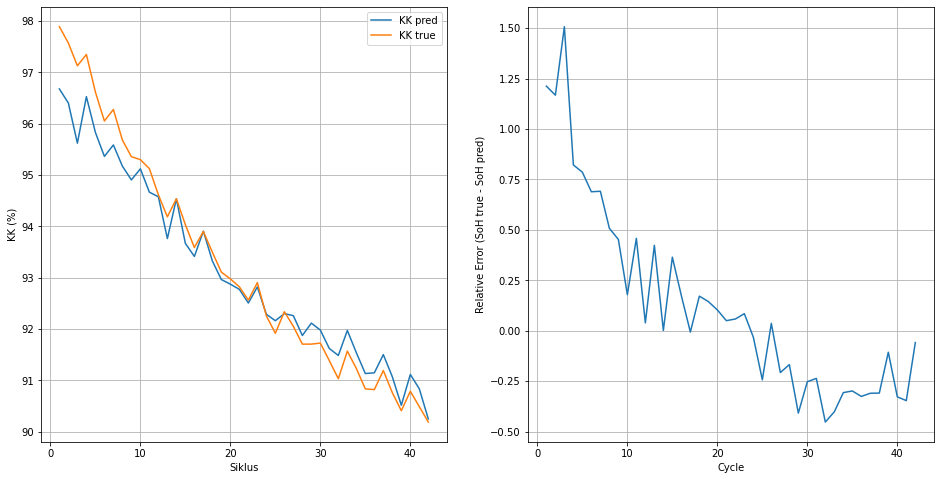

In [9]:
data['selisih']=0
data['selisih']=data.SoH_pred.iloc[1:].reset_index(drop=True)-data.SoH_pred[:-1].reset_index(drop=True)

cyc_dat=pd.DataFrame()
for cyc in data.Cycle.unique():
    df=data[data['Cycle']==cyc]
    cyc_dat=cyc_dat.append(df.iloc[-1])

cyc_dat.reset_index(drop=True)

fig,ax=pl.subplots(1,2,figsize=(16,8))
ax[0].plot(cyc_dat.Cycle,cyc_dat.SoH_pred,label='KK pred')
ax[0].plot(cyc_dat.Cycle,cyc_dat.SoHcyc,label='KK true')
ax[0].set_xlabel('Siklus')
ax[0].set_ylabel('KK (%)')
#ax[0].set_ylim(80,95)
ax[0].legend()
ax[0].grid()

ax[1].plot(cyc_dat.Cycle,cyc_dat.SoHcyc-cyc_dat.SoH_pred)
ax[1].set_xlabel('Cycle')
ax[1].set_ylabel('Relative Error (SoH true - SoH pred)')
ax[1].grid()

pl.rcParams['axes.labelsize'] = 18
pl.rcParams['xtick.labelsize'] = 14
pl.rcParams['ytick.labelsize'] = 14

In [14]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from math import sqrt

y_pred = regressor.predict(X_std)
MSE=mean_squared_error(y,y_pred)
MAE=mean_absolute_error(y,y_pred)
RMSE=sqrt(mean_squared_error(y,y_pred))
Skor=r2_score(y,y_pred)
def mape(y, y_pred): 
    y, y_pred = np.array(y), np.array(y_pred)
    return np.mean(np.abs((y - y_pred) / y)) * 100

print('MAPE prekdisi =',mape(y, y_pred))
print('MSE prediksi/estimasi pada data tes=',MSE)
print('Score prediksi/estimasi pada data tes=',Skor)
print('MAE prekdisi/estimasi pada data tes=',MAE)
print('RMSE prekdisi/estimasi pada data tes=',RMSE)
print('MAPE prekdisi/estimasi pada data tes=',mape)

MSE prediksi/estimasi pada data tes= 0.20696614557123905
Score prediksi/estimasi pada data tes= 0.999715486762976
MAE prekdisi/estimasi pada data tes= 0.3769219933284513
RMSE prekdisi/estimasi pada data tes= 0.4549353202063333
MAPE prekdisi/estimasi pada data tes= 4.1621321432
